In [3]:
%load_ext autoreload
%autoreload 2

## Basic setup

In [4]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0

/home/ec2-user/miniforge3/envs/concord/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [5]:
import time
from pathlib import Path
proj_name = "lungv1_hyper"
file_name = proj_name
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [6]:
DATA_FILE     = 'Lung_atlas_public.h5ad'
adata = sc.read_h5ad(data_dir / DATA_FILE)

### Create jobs

In [12]:
adata.obs

,dataset,location,nGene,nUMI,patientGroup,percent.mito,protocol,sanger_type,size_factors,sampling_method,batch,cell_type,donor
index,,,,,,,,,,,,,
GAGGGGCCAGCC,Dropseq_transplant,Dropseq_lower,249,355,nan,0.019718,drop-seq,drop-seq,0.381231,Transplant,B1,Type 2,B1
ACATAGATAGGC,Dropseq_transplant,Dropseq_lower,582,987,nan,0.044580,drop-seq,drop-seq,1.081643,Transplant,B1,Type 2,B1
ATCGACGCGGCA,Dropseq_transplant,Dropseq_lower,292,490,nan,0.026531,drop-seq,drop-seq,0.497352,Transplant,B1,Type 2,B1
CCAGCTTAGGTT,Dropseq_transplant,Dropseq_lower,1057,1806,nan,0.035437,drop-seq,drop-seq,2.172617,Transplant,B1,Type 2,B1
TCATAGAGTCCT,Dropseq_transplant,Dropseq_lower,716,1378,nan,0.020319,drop-seq,drop-seq,1.197578,Transplant,B1,Type 2,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG,10x_Transplant,Transplant,1178,3245,Parenchyma,0.011896,10x v2,other,0.775650,Transplant,5,Mast cell,5
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC,10x_Transplant,Transplant,1919,5984,Parenchyma,0.018747,10x v2,other,0.982236,Transplant,5,Mast cell,5
LungTranscriptome7239213_GACTGCGTCCTGCCAT,10x_Transplant,Transplant,4411,25233,Parenchyma,0.010489,10x v2,other,1.235763,Transplant,3,Mast cell,3


In [13]:
import json, math, subprocess, scanpy as sc
from pathlib import Path

# ------------------------------------------------------------
# 1. global sweep settings
# ------------------------------------------------------------
TOTAL_STEPS   = 3000          # keep *updates* per run constant
BASE_LR       = 1e-2            # lr used at BASE_BATCH
BASE_BATCH    = 256              # reference batch for LR scaling


N_CELLS = adata.n_obs
print(f"✔ Dataset has {N_CELLS:,} cells")
vegs = {
    1000 : ccd.ul.select_features(adata, n_top_features=1000,
                                  flavor="seurat_v3"),
    3000 : ccd.ul.select_features(adata, n_top_features=3000,
                                  flavor="seurat_v3"),
    4000 : ccd.ul.select_features(adata, n_top_features=4000,
                                  flavor="seurat_v3"),
    5000 : ccd.ul.select_features(adata, n_top_features=5000,
                                  flavor="seurat_v3"),
    6000 : ccd.ul.select_features(adata, n_top_features=6000,
                                  flavor="seurat_v3"),
    8000 : ccd.ul.select_features(adata, n_top_features=8000,
                                  flavor="seurat_v3"),
    10000: ccd.ul.select_features(adata, n_top_features=10000,
                                  flavor="seurat_v3"),
}

✔ Dataset has 32,472 cells
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...


In [14]:
# HCL mode jobs
# ------------------------------------------------------------
DATA_FILE     = 'Lung_atlas_public.h5ad'
# ------------------------------------------------------------

feature_list = ccd.ul.select_features(adata, n_top_features=5000, flavor='seurat_v3')
hcl_base_args = {
    "latent_dim": 50,
    "batch_size": BASE_BATCH,
    "input_feature": feature_list,
    "encoder_dims": [500],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.0,
    "clr_beta": 1.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.40,
    "sampler_knn": 1000,
    "dropout_prob": 0.0,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}


param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "clr_beta" : [0.0, 0.5, 1.0, 2.0, 6.0],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 5 values
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "n_epochs": [1, 2, 3, 4, 5, 10, 15, 20, 30],  # sweep 9 values
    "encoder_dims": [[50], [100], [500], [1000], [2000], [5000]],  # fixed
    "input_feature": list(vegs.values())
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
hcl_jobs = ccd.bm.expand_one_at_a_time(
    hcl_base_args,
    param_grid,
    base_tag="concord_hcl",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in hcl_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE,
        "--methods",        "concord_hcl",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "concord",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(hcl_jobs)} jobs for concord_hcl mode in {output_dir}")

concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
✔ 16 batch size: 2 epochs, 2030 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-16.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-16.sh

✔ 32 batch size: 3 epochs, 1015 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-32.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-32.sh

✔ 64 batch size: 6 epochs, 508 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-64.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-64.sh

✔ 128 batch size: 12 epochs, 254 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_hcl_concord_hcl_batch_size-128.py
✅ Ge

In [15]:
# KNN mode jobs
# ------------------------------------------------------------
# 2. base & grid
# ------------------------------------------------------------
knn_base_args = {
    "latent_dim": 50,
    "batch_size": BASE_BATCH,
    "input_feature": feature_list,
    "encoder_dims": [500],
    "p_intra_domain": 1.0,
    "p_intra_knn": 0.3,
    "clr_beta": 0.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "dropout_prob": 0.0,
    "n_epochs": 15,        # gets overwritten below
    "lr":       BASE_LR,   # gets overwritten below
    "save_dir": "../" + str(save_dir),
}


param_grid = {
    "batch_size":  [16, 32, 64, 128, 256, 512, 1024, 2048],     # sweep 2 values
    "latent_dim":  [10, 50, 100, 500, 1000],    # sweep 2 values
    "p_intra_domain": [0.6, 0.7, 0.8, 0.9, 0.95, 1.0],  # sweep 6 values
    "p_intra_knn" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
    "sampler_knn": [100, 300, 1000, 3000, 10000],  # sweep 5 values
    "augmentation_mask_prob": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
    "clr_temperature": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],  # sweep 
    "encoder_dims": [[50], [100], [500], [1000], [2000], [5000]],  # fixed
    "n_epochs": [1,2,3,4,5, 10, 15, 20, 30],
    "input_feature": list(vegs.values())
}

# ------------------------------------------------------------
# 3. expand jobs (one-at-a-time)
# ------------------------------------------------------------
knn_jobs = ccd.bm.expand_one_at_a_time(
    knn_base_args,
    param_grid,
    base_tag="concord_knn",
)

# ------------------------------------------------------------
# 4. adjust epochs + lr for each job
# ------------------------------------------------------------
output_dir = "../jobs"
verbose    = False          # add --verbose when needed

for kw in knn_jobs:
    B = kw["batch_size"]

    # a) compute epochs so updates == TOTAL_STEPS
    steps_per_epoch = math.ceil(N_CELLS / B)
    kw["n_epochs"]  = math.ceil(TOTAL_STEPS / steps_per_epoch)
    print(f"✔ {kw['batch_size']:,} batch size: {kw['n_epochs']} epochs, {steps_per_epoch} steps per epoch")

    # b) scale learning-rate linearly with batch size
    # kw["lr"] = BASE_LR #* B / BASE_BATCH
    kw["lr"] = BASE_LR 

    # --------------------------------------------------------
    # 5. hand off to script generator
    # --------------------------------------------------------
    cmd = [
        "python", "./generate_py_jobs.py",
        "--proj_name",      proj_name,
        "--adata_filename", DATA_FILE,
        "--methods",        "concord_knn",
        "--batch_key",      "batch",
        "--state_key",      "None",
        "--latent_dim",     str(kw["latent_dim"]),
        "--output_dir",     output_dir,
        "--device",         "auto",
        "--conda_env",      "concord",
        "--runtime",        "02:00:00",
        "--concord_kwargs", json.dumps(kw),
    ]
    if verbose:
        cmd.append("--verbose")

    subprocess.run(cmd, check=True)

print(f"✔ Generated {len(knn_jobs)} jobs for concord_knn mode in {output_dir}")

✔ 16 batch size: 2 epochs, 2030 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-16.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-16.sh

✔ 32 batch size: 3 epochs, 1015 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-32.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-32.sh

✔ 64 batch size: 6 epochs, 508 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-64.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-64.sh

✔ 128 batch size: 12 epochs, 254 steps per epoch
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-128.py
✅ Generated: benchmark_lungv1_hyper/benchmark_lungv1_hyper_concord_knn_concord_knn_batch_size-128.sh

✔ 

In [16]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_lungv1_hyper/submit_all_lungv1_hyper.sh” to queue every job.


In [17]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = f"""#!/usr/bin/env bash
set -euo pipefail
cd "$(dirname "$0")"            # work inside this folder (../jobs)
shopt -s nullglob

for job in benchmark_{proj_name}_*.py; do
  base=${{job%.py}}
  log="${{base}}.log"

  # ───────────────────────────────────────────────────────────────
  # skip if a previous run finished successfully
  # ───────────────────────────────────────────────────────────────
  if [[ -f "$log" ]] && grep -q "finished OK" "$log"; then
      echo ">>> SKIP $job  — already completed"
      continue
  fi

  echo ">>> $job   $(date)" | tee -a "$log"
  if python "$job" >>"$log" 2>&1; then
      echo ">>> finished OK" | tee -a "$log"
  else
      echo ">>> FAILED"      | tee -a "$log"
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_lungv1_hyper/submit_sequential_lungv1_hyper.sh” to queue jobs sequentially.


### Collect results

In [7]:
DATA_FILE     = 'Lung_atlas_public.h5ad'
adata = sc.read_h5ad(data_dir / DATA_FILE)

In [10]:
# hcl_keys = [kw['output_key'] for kw in hcl_jobs]
# knn_keys = []
# methods = hcl_keys + knn_keys
# print(f"total methods: {len(methods)}")

# Auto detect runned methods in the save_dir
import re
from typing import List, Optional
_RUN_DIR_RE = re.compile(r'^(concord_(?:hcl|knn)_.+?)_\d{4}-\d{4}$')

def discover_methods(save_root: Path) -> List[str]:
    """
    Scan `save_root` for run folders and return a sorted list of
    unique method prefixes (without the timestamp).
    """
    methods = {
        m.group(1)
        for p in save_root.iterdir()
        if p.is_dir() and (m := _RUN_DIR_RE.match(p.name))
    }
    return sorted(methods)

methods = discover_methods(save_dir)
methods

['concord_hcl_augmentation_mask_prob-0.1',
 'concord_hcl_augmentation_mask_prob-0.2',
 'concord_hcl_augmentation_mask_prob-0.3',
 'concord_hcl_augmentation_mask_prob-0.4',
 'concord_hcl_augmentation_mask_prob-0.5',
 'concord_hcl_augmentation_mask_prob-0.6',
 'concord_hcl_augmentation_mask_prob-0.7',
 'concord_hcl_augmentation_mask_prob-0.8',
 'concord_hcl_batch_size-1024',
 'concord_hcl_batch_size-128',
 'concord_hcl_batch_size-16',
 'concord_hcl_batch_size-2048',
 'concord_hcl_batch_size-256',
 'concord_hcl_batch_size-32',
 'concord_hcl_batch_size-512',
 'concord_hcl_batch_size-64',
 'concord_hcl_clr_beta-0.0',
 'concord_hcl_clr_beta-0.5',
 'concord_hcl_clr_beta-1.0',
 'concord_hcl_clr_beta-2.0',
 'concord_hcl_clr_beta-6.0',
 'concord_hcl_clr_temperature-0.1',
 'concord_hcl_clr_temperature-0.2',
 'concord_hcl_clr_temperature-0.3',
 'concord_hcl_clr_temperature-0.4',
 'concord_hcl_clr_temperature-0.5',
 'concord_hcl_clr_temperature-0.6',
 'concord_hcl_clr_temperature-0.7',
 'concord_hc

In [11]:
#methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
#adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad') # Load the log normalized but unfiltered adata
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)
methods = [m for m in methods if m in adata.obsm.keys()]

✅ obsm['concord_hcl_augmentation_mask_prob-0.1'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.2'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.3'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.4'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.5'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.6'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.7'] loaded
✅ obsm['concord_hcl_augmentation_mask_prob-0.8'] loaded
✅ obsm['concord_hcl_batch_size-1024'] loaded
✅ obsm['concord_hcl_batch_size-128'] loaded
✅ obsm['concord_hcl_batch_size-16'] loaded
✅ obsm['concord_hcl_batch_size-2048'] loaded
✅ obsm['concord_hcl_batch_size-256'] loaded
✅ obsm['concord_hcl_batch_size-32'] loaded
✅ obsm['concord_hcl_batch_size-512'] loaded
✅ obsm['concord_hcl_batch_size-64'] loaded
✅ obsm['concord_hcl_clr_beta-0.0'] loaded
✅ obsm['concord_hcl_clr_beta-0.5'] loaded
✅ obsm['concord_hcl_clr_beta-1.0'] loaded
✅ obsm['concord_hcl_clr_beta-2.0'] loaded
✅ obsm['concord_hcl_clr_beta-6.0'

### Benchmarking

✅ Benchmark summary saved to: ../save/lungv1_hyper/benchmark_summary_Jul10-0024.tsv


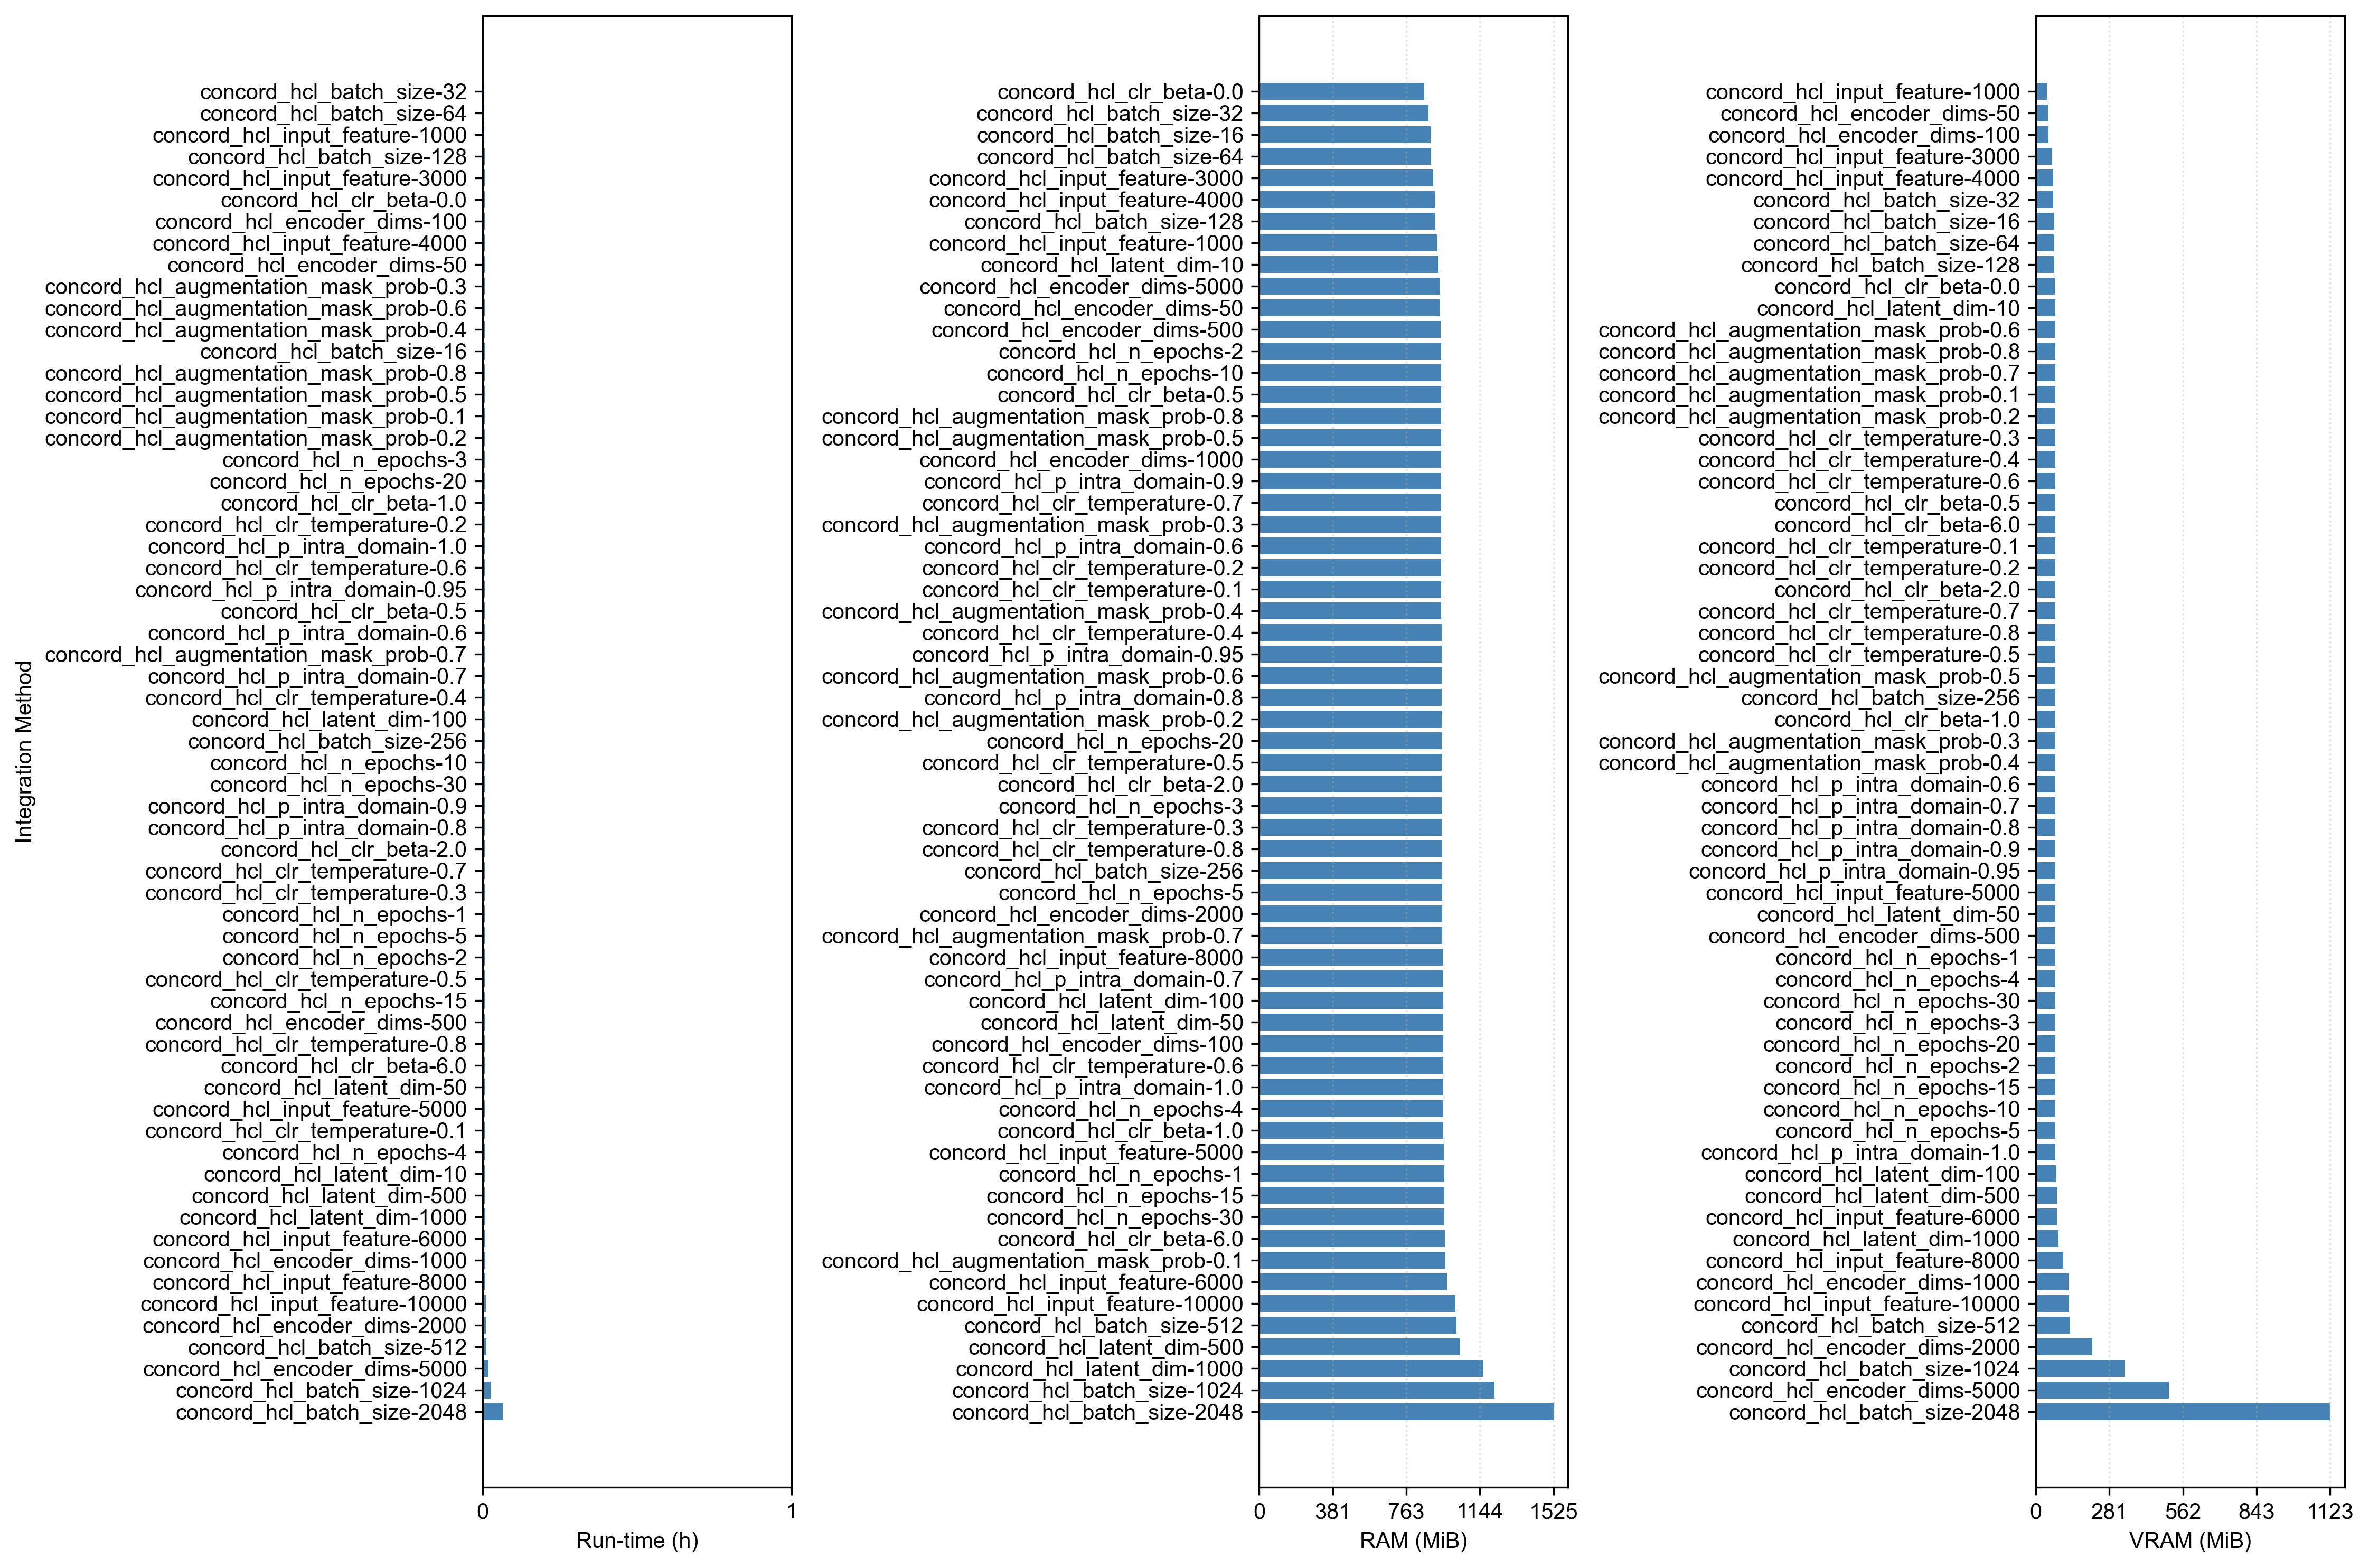

In [19]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(15,10), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


In [20]:
adata.obs

,dataset,location,nGene,nUMI,patientGroup,percent.mito,protocol,sanger_type,size_factors,sampling_method,batch,cell_type,donor
index,,,,,,,,,,,,,
GAGGGGCCAGCC,Dropseq_transplant,Dropseq_lower,249,355,nan,0.019718,drop-seq,drop-seq,0.381231,Transplant,B1,Type 2,B1
ACATAGATAGGC,Dropseq_transplant,Dropseq_lower,582,987,nan,0.044580,drop-seq,drop-seq,1.081643,Transplant,B1,Type 2,B1
ATCGACGCGGCA,Dropseq_transplant,Dropseq_lower,292,490,nan,0.026531,drop-seq,drop-seq,0.497352,Transplant,B1,Type 2,B1
CCAGCTTAGGTT,Dropseq_transplant,Dropseq_lower,1057,1806,nan,0.035437,drop-seq,drop-seq,2.172617,Transplant,B1,Type 2,B1
TCATAGAGTCCT,Dropseq_transplant,Dropseq_lower,716,1378,nan,0.020319,drop-seq,drop-seq,1.197578,Transplant,B1,Type 2,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG,10x_Transplant,Transplant,1178,3245,Parenchyma,0.011896,10x v2,other,0.775650,Transplant,5,Mast cell,5
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC,10x_Transplant,Transplant,1919,5984,Parenchyma,0.018747,10x v2,other,0.982236,Transplant,5,Mast cell,5
LungTranscriptome7239213_GACTGCGTCCTGCCAT,10x_Transplant,Transplant,4411,25233,Parenchyma,0.010489,10x v2,other,1.235763,Transplant,3,Mast cell,3


concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['concord_hcl_augmentation_mask_prob-0.1', 'concord_hcl_augmentation_mask_prob-0.2', 'concord_hcl_augmentation_mask_prob-0.3', 'concord_hcl_augmentation_mask_prob-0.4', 'concord_hcl_augmentation_mask_prob-0.5', 'concord_hcl_augmentation_mask_prob-0.6', 'concord_hcl_augmentation_mask_prob-0.7', 'concord_hcl_augmentation_mask_prob-0.8', 'concord_hcl_batch_size-1024', 'concord_hcl_batch_size-128', 'concord_hcl_batch_size-16', 'concord_hcl_batch_size-2048', 'concord_hcl_batch_size-256', 'concord_hcl_batch_size-32', 'concord_hcl_batch_size-512', 'concord_hcl_batch_size-64', 'concord_hcl_clr_beta-0.0', 'concord_hcl_clr_beta-0.5', 'concord_hcl_clr_beta-1.0', 'concord_hcl_clr_beta-2.0', 'concord_hcl_clr_beta-6.0', 'concord_hcl_clr_temperature-0.1', 'concord_hcl_clr_temperature-0.2', 'concord_hcl_clr_temperature-0.3', 'concord_hcl_clr_temperature-0.4',

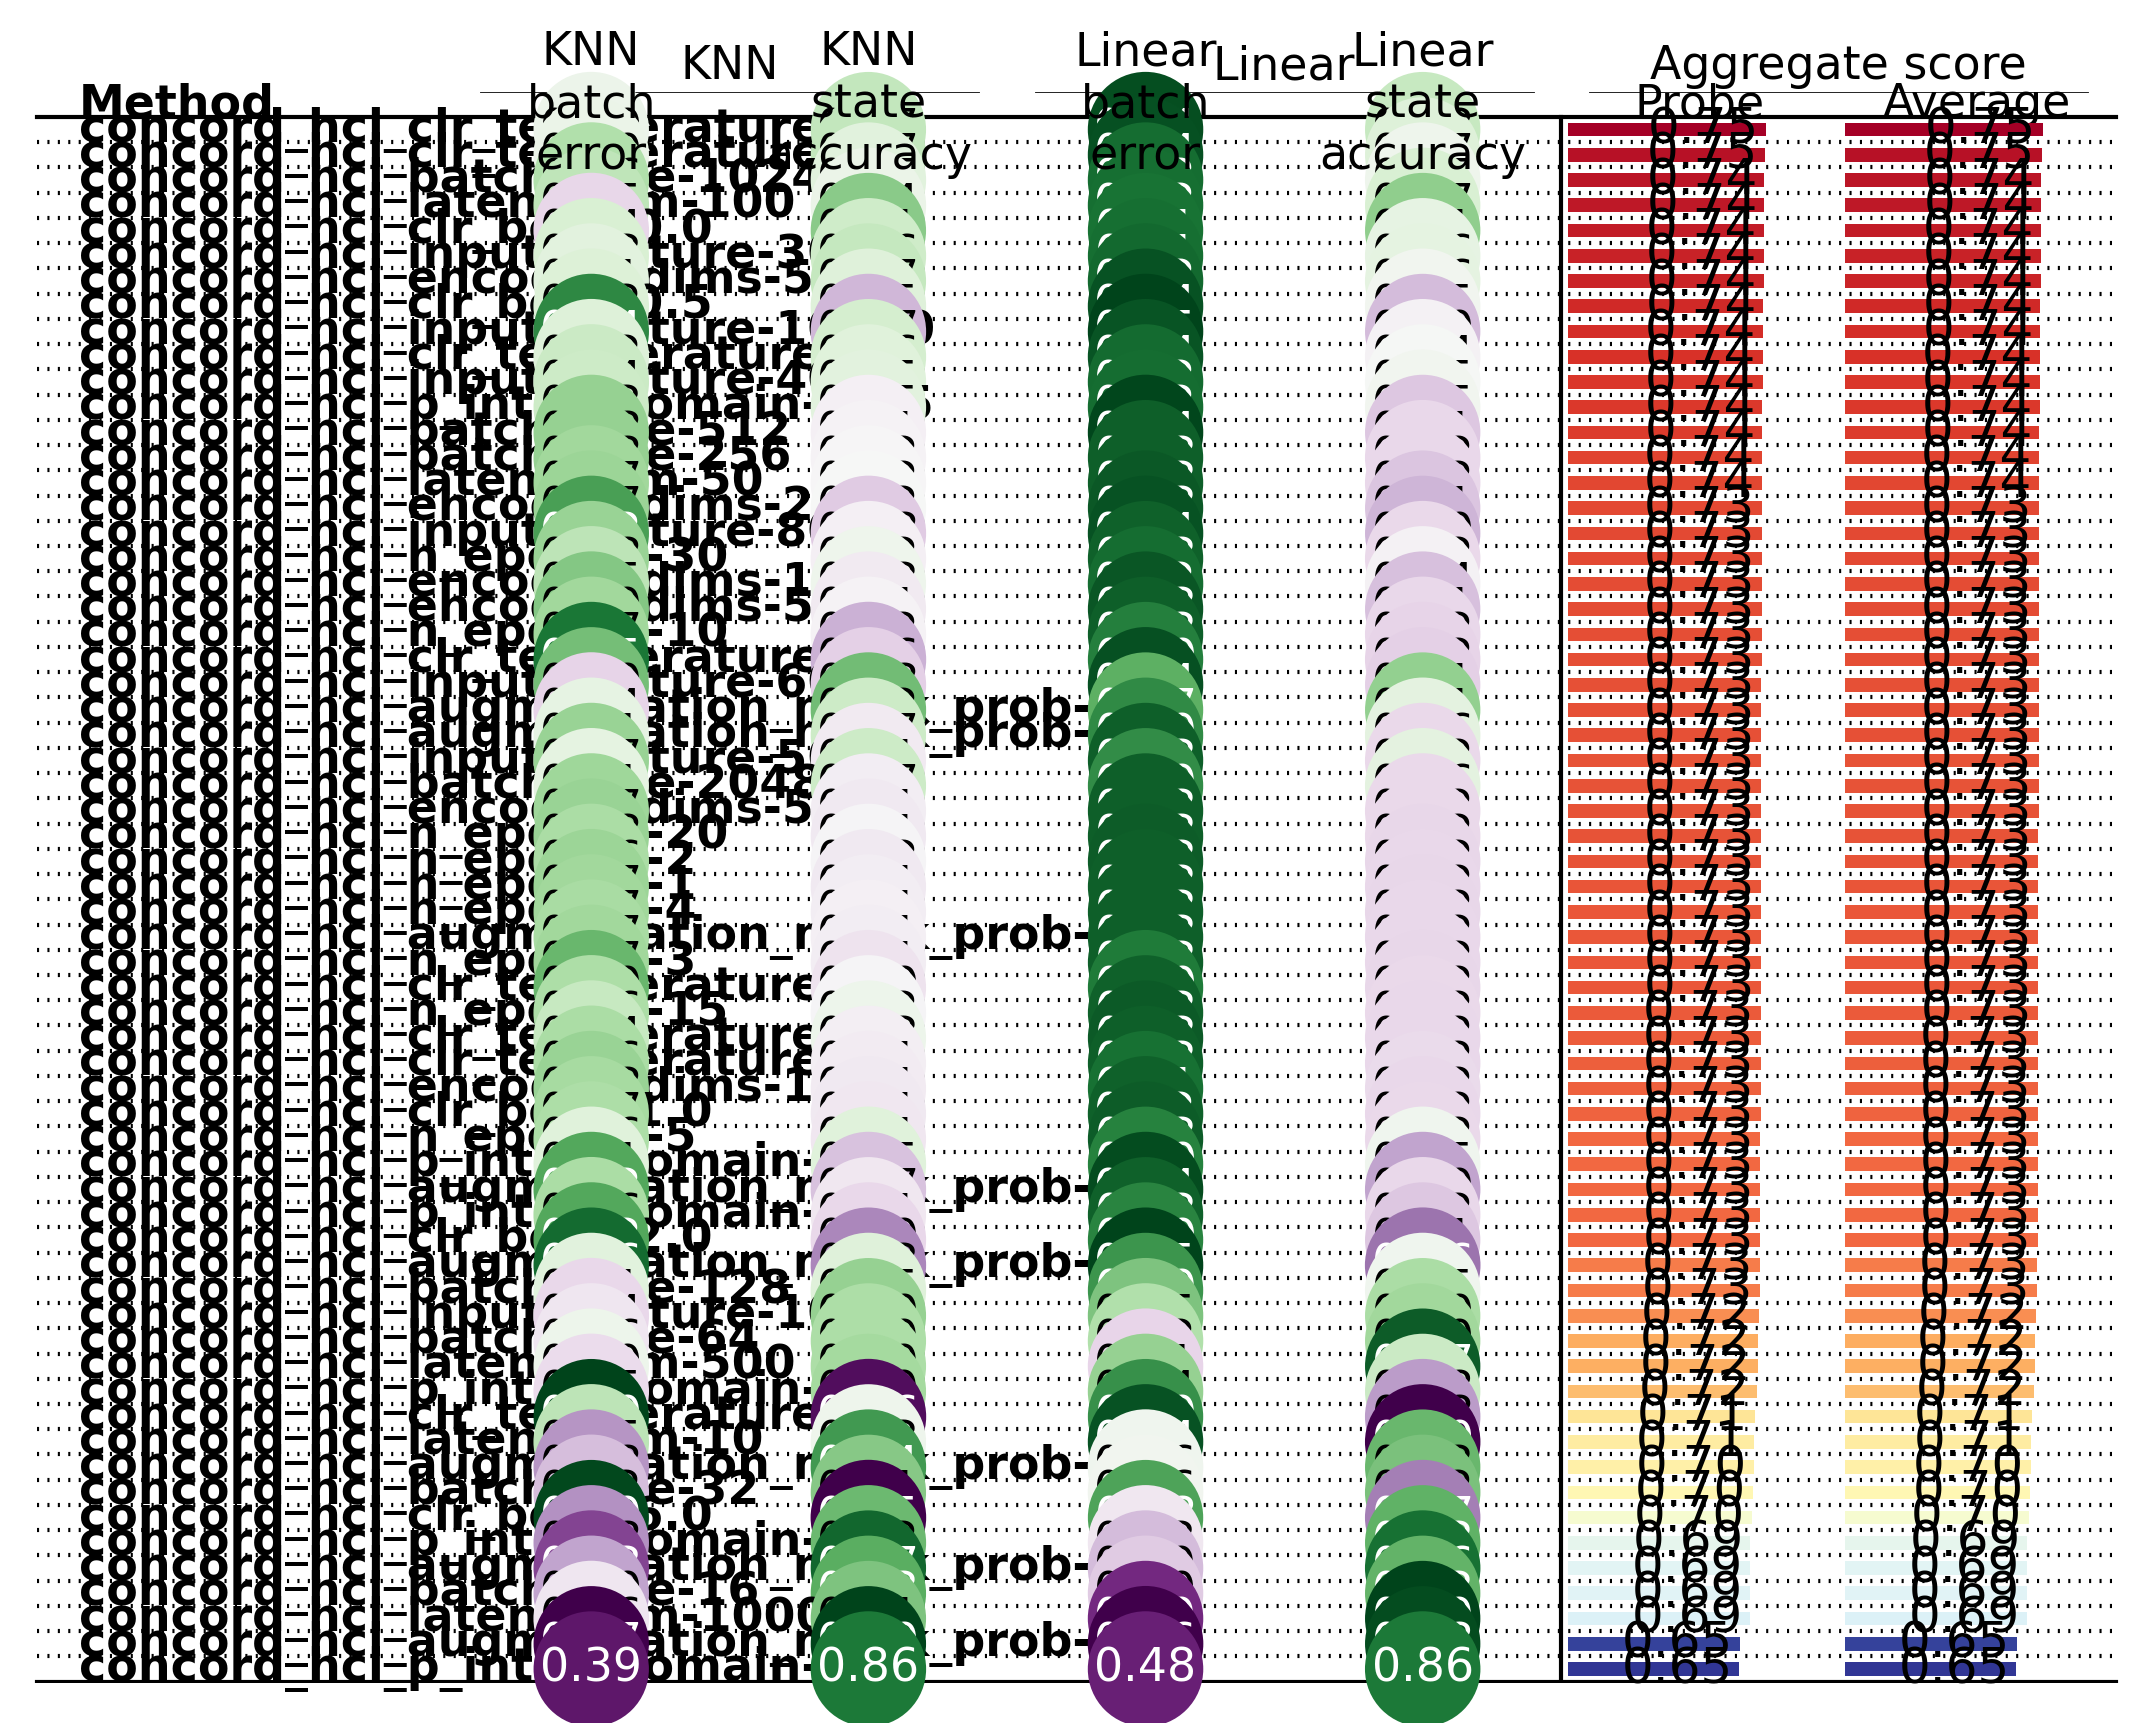

✅ Benchmark results saved to: ../save/lungv1_hyper/benchmark_cell_type_Jul10-0024.pkl


In [21]:
state_key = 'cell_type'
batch_key = 'batch'
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [22]:
combined_celltype.to_csv(save_dir / f"combined_celltype_{file_suffix}.tsv", sep="\t", index=True)
print(f"✅ Combined cell type results saved to: {save_dir / f'combined_celltype_{file_suffix}.tsv'}")

✅ Combined cell type results saved to: ../save/lungv1_hyper/combined_celltype_Jul10-0024.tsv


In [ ]:
import re
from pathlib import Path
import itertools

import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 0  CONFIG ─ paths, metric, cosmetics
# ───────────────────────────────────────────────────────────────
SAVE_ROOT   = save_dir
FILE_SUFFIX = file_suffix

CELL_TSV   = SAVE_ROOT / f"combined_celltype_{FILE_SUFFIX}.tsv"

BASE_CELL  = Path("../save/lungv1_5k/") / f"other_celltype_Jul03-1254.tsv"

METRIC_COL = "Aggregate score.1"          # ← use any column you like

COLORS     = {"Cell type": "#1f77b4",     # consistent colour palette
              "Lineage":   "#ff7f0e"}

# dash patterns for up to 8 baselines – extend / customise as needed
DASHES = ["solid", "dashed", "dotted", "dashdot",
          (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (1, 1)), (0, (5, 1, 1, 1))]
# ───────────────────────────────────────────────────────────────
# 1  Helpers
# ───────────────────────────────────────────────────────────────
score_cols = ["KNN", "KNN.1", "Linear", "Linear.1",
              "Aggregate score", "Aggregate score.1"]

_method_re = re.compile(
    r"concord_(hcl|knn)_(.+?)[-_]([0-9.]+)$"   # note  [-_]
)

def parse_method(name: str):
    m = _method_re.match(name)
    if m is None:
        return None, None, None
    mode, param, val = m.groups()
    try:
        val = float(val) if "." in val else int(val)
    except ValueError:
        pass
    return mode, param, val

def load_hyperparam_table(path: Path, target_label: str) -> pd.DataFrame:
    """Read hyper-parameter sweep table and return tidy frame."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df[["mode", "param", "value"]] = df["Unnamed: 0"].apply(
        lambda s: pd.Series(parse_method(s))
    )
    print(df)
    df["acc"]   = df[METRIC_COL]
    df["target"] = target_label
    return df.dropna(subset=["mode", "param"])


def load_baseline_table(path: Path, target_label: str) -> pd.DataFrame:
    """Baseline tables have one row per method (no hyper-params)."""
    df = pd.read_csv(path, sep="\t").iloc[2:].copy()
    df[score_cols] = df[score_cols].apply(pd.to_numeric, errors="coerce")
    df["method"]  = df["Unnamed: 0"].str.strip()
    df["acc"]     = df[METRIC_COL]
    df["target"]  = target_label
    return (df[["method", "acc", "target"]]
              .dropna(subset=["method"]))

# ───────────────────────────────────────────────────────────────
# 2  Load and fuse data
# ───────────────────────────────────────────────────────────────
hp_cell  = load_hyperparam_table(CELL_TSV,  "Cell type")

hyper_df = pd.concat([hp_cell, hp_line], ignore_index=True)

baseline_cell = load_baseline_table(BASE_CELL, "Cell type")
baseline_df   = pd.concat([baseline_cell, baseline_line], ignore_index=True)

# mean across repeats (if any)
hp_summary = (hyper_df
              .groupby(["mode", "param", "value", "target"], as_index=False)["acc"]
              .mean())

base_summary = (baseline_df
                .groupby(["method", "target"], as_index=False)["acc"]
                .mean())

# Drop previous concord_hcl and concord_knn methods
base_summary = base_summary[~base_summary["method"].isin(["concord_hcl", "concord_knn", "seurat_cca"])]

# assign dash-patterns to each method
style_map = {m: d for m, d in zip(base_summary["method"].unique(),
                                  itertools.cycle(DASHES))}


In [ ]:
data_path = data_dir / 'Lung_atlas_public.h5ad'
adata = sc.read(
    data_path
)

In [ ]:
adata.obsm.keys()

In [ ]:
from benchmark_utils import add_embeddings
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

In [ ]:
# Run umap for all latent embeddings
for basis in methods:
    print("Running UMAP for", basis)
    if basis not in adata.obsm:
        print(f"{basis} not found.")
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)

# Save obsm 
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"{file_name}_obsm_final.h5")
adata.write_h5ad(data_dir / f"{file_name}_adata_final.h5ad")
print(f"✅ Saved adata with embeddings to {data_dir / f'{file_name}_adata_final.h5ad'}")

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = methods
show_cols = ['dataset', 'nGene', 'protocol', 'batch', 'donor', 'cell_type']
basis_types = ['UMAP']

font_size=10
point_size=.1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        #pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


In [ ]:
basis = 'concord_knn'
show_basis = basis + '_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(13,8), dpi=600, ncols=3, font_size=10, point_size=1, legend_loc="on data",
    save_path=save_dir / f"{show_basis}_{file_suffix}.pdf"
)

### Separately run CONCORD

In [ ]:
data_path = data_dir / 'Lung_atlas_public.h5ad'
adata = sc.read(
    data_path
)

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [ ]:
concord_args = {
        'adata': adata,
        'input_feature': adata.var[adata.var['highly_variable']].index.tolist(),
        'latent_dim': 30,
        'batch_size': 256,
        'augmentation_mask_prob': 0.3, 
        'clr_temperature': 0.5,
        'p_intra_knn': 0.0,
        'clr_beta': 0.2,
        'sampler_knn': 300,
        'sampler_emb': 'X_pca',
        'p_intra_domain': 1.0,
        'n_epochs': 10,
        'domain_key': 'batch',
        'verbose': True,
        'seed': seed,
        'device': device,
        'save_dir': save_dir,
        'load_data_into_memory': True,
    }

output_key = f'Concord_knn'
cur_ccd = ccd.Concord(**concord_args)
cur_ccd.fit_transform(output_key=output_key)

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
#output_key = 'Concord'
show_cols = ['protocol', 'batch', 'cell_type']
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(10,3), dpi=300, ncols=3, font_size=5, point_size=3, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)